- Author: Anja Marunovic
- Email: anja.marun@gmail.com
- Amsterdam, 23 May 2018


# KPN case Objective:
----------------------------------
 Rebtel wants to gain insight in customers' sentiments towards Rebtel, and possible drivers for these sentiments.
 You are a Rebtel data scientist, and you've been asked to analyze the online reviews on Rebtel.
To this end, you want to create a model that is capable of predicting the rating/sentiment an author would give.


# Content:
- Import data created by scraping in R
- Preprocess the text
- Part I: 
  - A. Modelling reviews ~ ratings
       - Try different models
       - Evaluate models
       - Perform Grid Search for best performance
  - B. Modelling reviews ~ ratings with downsampling
       - Try different models
       - Evaluate models
       - Perform Grid Search for best performance
- Part II: 
  - A. Modelling reviews ~ positivity
       - Try different models
       - Evaluate models
       - Perform Grid Search for best performance
  - B. Modelling reviews ~ positivity with downsampling
       - Try different models
       - Evaluate models
       - Perform Grid Search for best performance

# IMPORT FUNCTIONS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [4]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [6]:
pd.set_option('display.max_colwidth', 8000),
pd.set_option('display.max_columns', None)

## TEXT PREPROCESSING

In [7]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words



In [8]:
import string
def text_process(text):
    lemmatizer = WordNetLemmatizer()
    '''
    Takes in a string of text, then performs the following:
    1. Remove non-ASCII characters
    2. Remove all punctuation
    3. Convert to lower case
    4. Remove all stopwords
    5. Lemmatize words
    6. Return the cleaned text as a list of words
    '''
    nopunc = [unicodedata.normalize('NFKD', char).encode('ascii', 'ignore').decode('utf-8', 'ignore') for char in text]
    nopunc = [char for char in nopunc if char not in string.punctuation]
    nopunc = [char.lower() for char in nopunc]
    nopunc = [char for char in nopunc if char not in stopwords.words('english')]
    nopunc = ''.join(nopunc)
    nopunc = ''.join(map(lambda c: '' if c in '0123456789' else c, nopunc))
    
    exclude = set(string.punctuation)
    nopunc = ''.join(map(lambda c: '' if c in exclude else c, nopunc))
        
    return [lemmatizer.lemmatize(word, pos='v') for word in nopunc.split() if word not in stopwords.words('english')]


import string
def text_process_2(text):
    lemmatizer = WordNetLemmatizer()
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Lemmatize words
    4. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [lemmatizer.lemmatize(word, pos='v') for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# IMPORT DATA

In [2]:
rebtel = pd.read_csv('C:/Users/Thomas/Desktop/Desktop/Rebtel.tsv',delimiter='\t',encoding='utf-8')

---------------------------------------------------
# PART I
---------------------------------------------------

# I.A     Modelling reviews ~ ratings

In [9]:
X = rebtel['review']
y = rebtel['rating']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## SVM

In [11]:
# text process 2
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
                        ])
text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm))
print('\n')
print(classification_report(y_test, predicted_svm))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Overall Accuracy:  0.6038592508513053
[[135   0   0   2  32]
 [ 37   0   1   3  16]
 [ 22   0   7  13  39]
 [ 21   0   3  16 129]
 [ 21   0   1   9 374]]


             precision    recall  f1-score   support

          1       0.57      0.80      0.67       169
          2       0.00      0.00      0.00        57
          3       0.58      0.09      0.15        81
          4       0.37      0.09      0.15       169
          5       0.63      0.92      0.75       405

avg / total       0.53      0.60      0.52       881



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [2]:
print(2)

2


In [15]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
#ngram_range=(1,2)


In [16]:
feature_df = pd.DataFrame(svm.feature_importances_.tolist(),tfidf.get_feature_names())
feature_df.reset_index(inplace=True)
columns = ['feature','importance']
feature_df.columns = columns

AttributeError: 'SGDClassifier' object has no attribute 'feature_importances_'

- SVM output for analyzer = text_process_2
Overall Accuracy:  0.6038592508513053
[[135   0   0   2  32]
 [ 37   0   1   3  16]
 [ 22   0   7  13  39]
 [ 21   0   3  16 129]
 [ 21   0   1   9 374]]


             precision    recall  f1-score   support

          1       0.57      0.80      0.67       169
          2       0.00      0.00      0.00        57
          3       0.58      0.09      0.15        81
          4       0.37      0.09      0.15       169
          5       0.63      0.92      0.75       405

avg / total       0.53      0.60      0.52       881


## Naive Bayes

In [35]:

text_clf = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                    ])
text_clf = text_clf.fit(X_train,y_train)
predicted = text_clf.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted == y_test))
#
print(confusion_matrix(y_test, predicted))
print('\n')
print(classification_report(y_test, predicted))

Overall Accuracy:  0.5459704880817253
[[ 80   0   0   0  89]
 [ 17   0   0   0  40]
 [  9   0   0   0  72]
 [  5   0   0   0 164]
 [  4   0   0   0 401]]


             precision    recall  f1-score   support

          1       0.70      0.47      0.56       169
          2       0.00      0.00      0.00        57
          3       0.00      0.00      0.00        81
          4       0.00      0.00      0.00       169
          5       0.52      0.99      0.68       405

avg / total       0.37      0.55      0.42       881



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [10]:

text_clf_rf = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('rf', RandomForestClassifier()),
                    ])
text_clf_rf = text_clf_rf.fit(X_train,y_train)
predicted_rf = text_clf_rf.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_rf == y_test))
#
print(confusion_matrix(y_test, predicted_rf))
print('\n')
print(classification_report(y_test, predicted_rf))

Overall Accuracy:  0.5334846765039728
[[108   5   1   9  46]
 [ 30   3   3   6  15]
 [ 20   0   6  16  39]
 [ 19   1   3  34 112]
 [ 25   2   1  58 319]]


             precision    recall  f1-score   support

          1       0.53      0.64      0.58       169
          2       0.27      0.05      0.09        57
          3       0.43      0.07      0.13        81
          4       0.28      0.20      0.23       169
          5       0.60      0.79      0.68       405

avg / total       0.49      0.53      0.49       881



## SVM - Optimization - Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

In [ ]:

text_clf_svm_gs = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=0.001, n_iter=5, random_state=42)),
 ])
text_clf_svm_gs = text_clf_svm_gs.fit(X_train, y_train)
predicted_svm_gs = text_clf_svm_gs.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm_gs))
print('\n')
print(classification_report(y_test, predicted_svm_gs))

## NB Optimization - Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_score_
gs_clf.best_params_

In [ ]:
text_clf_gs = Pipeline([('vect', CountVectorizer(ngram_range=(1,2),analyzer=text_process)),
                      ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB(alpha=0.01)),
                    ])
text_clf_gs = text_clf_gs.fit(X_train,y_train)
predicted_gs = text_clf_gs.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_gs == y_test))
print('\n')
#
print(confusion_matrix(y_test, predicted))
print('\n')
print(classification_report(y_test, predicted))

## RF - Optimization - Grid Search

In [ ]:
from sklearn.grid_search import GridSearchCV
 
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(train_x, train_y)
print CV_rfc.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters_rf = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
gs_clf_rf = GridSearchCV(text_clf_rf, parameters_rf, n_jobs=-1)
gs_clf_rf = gs_clf_rf.fit(X_train, y_train)
gs_clf_rf.best_score_
gs_clf_rf.best_params_

- Comment: 
Best result gives SVM model. However, rating 2 is poorly predicted. 
This might be due to the fact that the set is unbalanced.
Use downsampling as the number of ratings 2  is much smaller then the number of ratings 4 and 5.

# I.A Modelling reviews ~ ratings with Downsampling

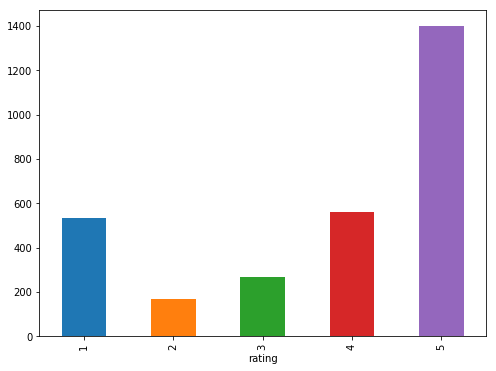

In [5]:
# Check distribution of scores 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
rebtel.groupby('rating').review.count().plot.bar(ylim=0)
plt.show()

In [20]:
score_1 = rebtel[rebtel.rating==1]
score_2 = rebtel[rebtel.rating==2]
score_3 = rebtel[rebtel.rating==3]
score_4 = rebtel[rebtel.rating==4]
score_5 = rebtel[rebtel.rating==5]

In [21]:
print("Numbers of reviews with score 1: ",len(score_1))
print("Numbers of reviews with score 2: ",len(score_2))
print("Numbers of reviews with score 3: ",len(score_3))
print("Numbers of reviews with score 4: ",len(score_4))
print("Numbers of reviews with score 5: ",len(score_5))

Numbers of reviews with score 1:  533
Numbers of reviews with score 2:  170
Numbers of reviews with score 3:  268
Numbers of reviews with score 4:  563
Numbers of reviews with score 5:  1400


In [22]:
# Downsampling to n = 170 number of reviews (to balance the set)
min_nr = 170
import random
score_1_downsample = score_1.sample(min_nr)
score_2_downsample = score_2
score_3_downsample = score_3.sample(min_nr)
score_4_downsample = score_4.sample(min_nr)
score_5_downsample = score_5.sample(min_nr)


In [23]:
len(score_2_downsample)

170

In [24]:
set_downsample = score_1_downsample.append(score_2_downsample).append(score_3_downsample).append(score_4_downsample).append(score_5_downsample)

In [25]:
X_ds = set_downsample['review']
y_ds = set_downsample['rating']

In [26]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.3, random_state=101)

## SVM - downsample

In [21]:
# text analyzer = text_processor 2
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
                        ])
text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm))
print('\n')
print(classification_report(y_test, predicted_svm))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Overall Accuracy:  0.396078431372549
[[29 17  2  2  4]
 [19 17 10  8  3]
 [10  8 12  6  6]
 [ 7  6  9 14 12]
 [ 3  5  3 14 29]]


             precision    recall  f1-score   support

          1       0.43      0.54      0.48        54
          2       0.32      0.30      0.31        57
          3       0.33      0.29      0.31        42
          4       0.32      0.29      0.30        48
          5       0.54      0.54      0.54        54

avg / total       0.39      0.40      0.39       255



## SVM downsample - Optimization - Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

In [ ]:
# text analyzer = normalize
text_clf_svm_gs = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=0.001, n_iter=5, random_state=42)),
 ])
text_clf_svm_gs = text_clf_svm_gs.fit(X_train, y_train)
predicted_svm_gs = text_clf_svm_gs.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm_gs))
print('\n')
print(classification_report(y_test, predicted_svm_gs))

--------------------------------------------------------------

# Part II

# II.A Modelling reviews ~ positivity

In [19]:
rebtel = pd.read_csv('C:/Users/Thomas/Desktop/Desktop/Rebtel.tsv',delimiter='\t',encoding='utf-8')

In [20]:
rebtel = rebtel[rebtel['rating'] != 3]
rebtel['positivity'] = np.where(rebtel['rating'] > 3, 1, 0)

In [21]:
X = rebtel['review']
y = rebtel['positivity']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## SVM

In [31]:
# text processor = text_process_2
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
                        ])
text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm))
print('\n')
print(classification_report(y_test, predicted_svm))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Overall Accuracy:  0.8925
[[144  69]
 [ 17 570]]


             precision    recall  f1-score   support

          0       0.89      0.68      0.77       213
          1       0.89      0.97      0.93       587

avg / total       0.89      0.89      0.89       800



### SVM - Optimization - Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

# RANDOM FOREST

In [19]:

text_clf_rf = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('rf', RandomForestClassifier()),
                    ])
text_clf_rf = text_clf_rf.fit(X_train,y_train)
predicted_rf = text_clf_rf.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_rf == y_test))
#
print(confusion_matrix(y_test, predicted_rf))
print('\n')
print(classification_report(y_test, predicted_rf))

Overall Accuracy:  0.85
[[126  87]
 [ 33 554]]


             precision    recall  f1-score   support

          0       0.79      0.59      0.68       213
          1       0.86      0.94      0.90       587

avg / total       0.85      0.85      0.84       800



## RF - Optimization - Grid Search

In [ ]:
# Use a grid over parameters of interest
parameters_rf = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
 
gs_clf_rf = GridSearchCV(text_clf_rf, parameters_rf, n_jobs=-1)
gs_clf_rf = gs_clf_rf.fit(X_train, y_train)
gs_clf_rf.best_score_
gs_clf_rf.best_params_
    

# NAIVE BAYES

In [18]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer=text_process)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                    ])
text_clf = text_clf.fit(X_train,y_train)
predicted = text_clf.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted == y_test))
#
print(confusion_matrix(y_test, predicted))
print('\n')
print(classification_report(y_test, predicted))

Overall Accuracy:  0.7925
[[ 47 166]
 [  0 587]]


             precision    recall  f1-score   support

          0       1.00      0.22      0.36       213
          1       0.78      1.00      0.88       587

avg / total       0.84      0.79      0.74       800



- Comment:
    All models give better result for predicting positivity
    Next step cn be downsampling again since distribution of positivities is not balanced

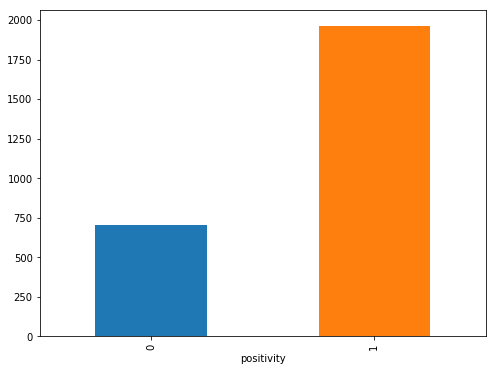

In [16]:
# Check distribution of scores 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
rebtel.groupby('positivity').review.count().plot.bar(ylim=0)
plt.show()

In [ ]:
rebtel.groupby('positivity').review.count()

## DOWNSAMPLING

In [23]:
score_0 = rebtel[rebtel.positivity==0]
score_1 = rebtel[rebtel.positivity==1]

In [25]:
print(len(score_0))
print(len(score_1))

703
1963


In [26]:
# Downsampling to n = 170 number of reviews (to balance the set)
min_nr = 703
import random
score_0_downsample = score_0
score_1_downsample = score_1.sample(min_nr)


In [28]:
set_downsample = score_0_downsample.append(score_1_downsample)

In [29]:
X_ = set_downsample['review']
y_ = set_downsample['positivity']

In [30]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.3, random_state=101)

In [31]:
X_train, X_test, y_train, y_test = X_train_, X_test_, y_train_, y_test_

## SVM

In [32]:
# text processor = normalize
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(analyzer=text_process_2)),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
                        ])
text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
print('Overall Accuracy: ', np.mean(predicted_svm == y_test))
#
print(confusion_matrix(y_test, predicted_svm))
print('\n')
print(classification_report(y_test, predicted_svm))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Overall Accuracy:  0.9004739336492891
[[190  22]
 [ 20 190]]


             precision    recall  f1-score   support

          0       0.90      0.90      0.90       212
          1       0.90      0.90      0.90       210

avg / total       0.90      0.90      0.90       422



In [86]:
test = [['rebtel is cheap'],
           ['rebtel is expensive'],
           ['i called my friend in india and they charged me so much\
           that i have to take a credit to pay it off'],
           ['i called kenya and they didnt charge me that much - love it'],           
           ['customer service doesnt exist'],
           ['customer service is great']]

In [106]:
test = [['rebtel is horrible'],['rebtel is horrble'],
       ['rebtel is bad'],['rebtel is bed']]

In [108]:
test = [['rebtel is so great that i will never recommend it to anyone'],\
        ['rebtel is amazing - when you call with rebtel the line is \
         breaking faster then the speed of light']]


In [109]:
text_clf_svm.predict(test)

array([1, 1])

In [71]:
test = [['rebtel is not cheap'],
           ['rebtel is not expensive']]

In [82]:
text_clf_svm.predict([['rebtel is so great that i will never recommend it to anyone'],\
                      ['rebtel is amazing - when you call with rebtel the line is breaking faster then the speed of light']])

array([1, 1])

- Comment:
 For better prediction:
    - improve cleaning: handle typos
    - spot sarcastic expressions